In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
'''
XGBOOST module

the module can be use for both classification and regression problem the appropriate objective method should be defined.
more information can be find here
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

User can define a customized objective function and evaluation function

optimization with grid search is easy first make a grid

make_grid(eta = [1, 2, 3], max_depth = [3, 4, 5])

then run the optimization
optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2)

to see the result and select best parameters
scores()


get the importance features and plot them is another awesome part of this module :)

get_importance()
plot_importance()


'''
import xgboost as xgb
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

color = sns.color_palette()

class XGBoost(object):
    def __init__(self, num_boost_round=10, objective=None, feval=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if objective:
            print("Built a XGBoost with defiend objective")
            if feval:
                if type(feval).__name__ == 'str':
                    print("Use eval_metric: ", feval)
                    self.params.update({'objective' : objective, 'eval_metric' : feval, 'silent' : True})
                else:
                    print("Use defiend funcation for eval")
                    self.params.update({'objective' : objective, 'silent' : True})
            else:
                print("Use default eval_metric")
                self.params.update({'objective' : objective, 'silent' : True})
                
        else:
            print("Built a XGBoost with default objective reg:linear")
            self.params.update({'objective' : 'reg:linear', 'silent' : True})
            
        print(self.params)

    def evalerror(self, preds, dtrain):
        labels = dtrain.get_label()
        return 'error', self.feval(labels, preds)

    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)

    def fit_eval(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 print_out=False):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        dtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [(dtrain, 'train'), (dtest, 'eval')]
        
        if type(self.feval).__name__ == 'str' or self.feval == None:
            self.clf = xgb.train(params = self.params, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        else:
            self.clf = xgb.train(params = self.params, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, feval = self.evalerror, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        
        if print_out:
            print("Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score)
        return self.clf.best_score

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def score(self, X, y):
        Y = self.predict(X)
        return self.feval(y, Y)

    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        return self.clf.get_fscore()

    def plot_importance(self, N = 10):
        importance = self.clf.get_fscore()

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()

    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return 
    
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print("Number of iteration for Optimization: ", len(self.grid_list))
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        dtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [(dtrain, 'train'), (dtest, 'eval')]

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in tqdm(range(len(self.grid_list))):
            temp = {}
            for j, key in enumerate(self.grid_params.keys()):
                temp[key] = self.grid_list[i][j]
#            print(temp)
            temp.update(self.params)
#            print(temp)

            if type(self.feval).__name__ == 'str' or self.feval == None:
                self.clf = xgb.train(params = temp, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
            else:
                self.clf = xgb.train(params = temp, dtrain = dtrain, num_boost_round = num_boost_round,
                             evals = watchlist, feval = self.evalerror, verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)

            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [self.clf.best_iteration, self.clf.best_score]], columns=col))


    def scores(self, N=4):
        return self.result.sort_values("score")[:N]
    
    def bayesian(self, X, y, X_test, y_test, nstopping = 5, ncalls = 10, warrning=False, **kwargs):
        if not warrning:
            print("Ignore UserWarning")
            warnings.filterwarnings("ignore")
        print(kwargs)
        space = []
        for key, val in kwargs.items():
            if key == "eta":
                space.append(Real(val[0], val[1], "log-uniform", name='eta'))
            elif key == "max_depth":
                space.append(Integer(val[0], val[1], name='max_depth'))
            elif key == 'subsample': 
                space.append(Real(val[0], val[1], "uniform", name='subsample'))
            elif key == 'colsample_bytree': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bytree'))
            elif key == 'colsample_bylevel': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bylevel'))
            elif key == "reg_lambda":
                space.append(Real(val[0], val[1], "log-uniform", name='reg_lambda'))
            elif key == "reg_alpha":
                space.append(Real(val[0], val[1], "log-uniform", name='reg_alpha'))
            elif key == "gamma":
                space.append(Real(val[0], val[1], "log-uniform", name='gamma'))
            elif key == "min_child_weight":
                space.append(Integer(val[0], val[1], name='min_child_weight'))
            elif key == "scale_pos_weight":
                space.append(Integer(val[0], val[1], name='scale_pos_weight'))
            else:
                print("Error: Invalid parameter")
                
                
        @use_named_args(space)
        def objective(**params):
            self.set_params(**params)

            return self.fit_eval(X, y, X_test, y_test, verbose_eval = False, num_boost_round = self.num_boost_round, 
                                 early_stopping = nstopping)
        

        res_gp = gp_minimize(objective, space, n_calls = ncalls, random_state=0)
    
        plot_convergence(res_gp)
        
        col = list(kwargs.keys()) + ['score']
        self.result = pd.DataFrame(columns=col)
        
        for val, score in zip(res_gp.x_iters, res_gp.func_vals):
            self.result = self.result.append(pd.DataFrame([val + [score]], columns=col))
        

# test the module

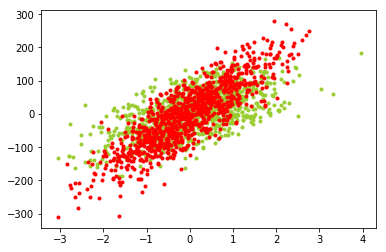

In [4]:
# create a dataset for regression problem
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=1)

X1, y1, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=0)

plt.scatter(X, y, color='yellowgreen', marker='.',
            label='Inliers')
#plt.show()

plt.scatter(X1, y1, color='red', marker='.',
            label='Inliers')
plt.show()

In [5]:
# Optimization Bayesian

In [6]:
model = XGBoost(objective = "reg:linear", num_boost_round = 1000)

Built a XGBoost with defiend objective
Use default eval_metric
{'objective': 'reg:linear', 'silent': True}


Ignore UserWarning
{'eta': [0.01, 0.05], 'max_depth': [4, 10], 'subsample': [0.5, 1.0], 'colsample_bytree': [0.5, 1.0], 'colsample_bylevel': [0.5, 1.0]}


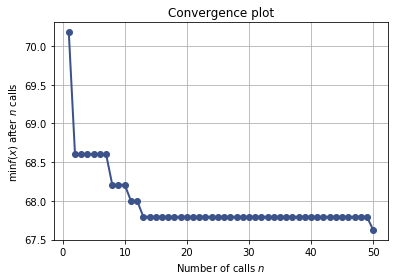

In [7]:
model.bayesian(X, y, X1, y1, nstopping = 10, ncalls=50, eta = [0.01, 0.05], max_depth = [4, 10],
               subsample = [0.5, 1.0], colsample_bytree = [0.5, 1.0], colsample_bylevel = [0.5, 1.0])

In [8]:
model.scores()

,eta,max_depth,subsample,colsample_bytree,colsample_bylevel,score
0,0.03469,4,0.5,1.000000,0.500000,67.624428
0,0.05000,4,0.5,0.983153,0.714719,67.794556
0,0.05000,4,0.5,1.000000,0.745561,67.794556
0,0.05000,4,0.5,1.000000,0.500000,67.794556


In [15]:
model = XGBoost(objective = "reg:linear", eta = 0.03469, max_depth = 4, subsample = 0.5,
                colsample_bytree = 1., colsample = 0.5)

Built a XGBoost with defiend objective
Use default eval_metric
{'eta': 0.03469, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample': 0.5, 'objective': 'reg:linear', 'silent': True}


In [16]:
model.fit_eval(X, y, X1, y1, verbose_eval = False, num_boost_round = 1000, early_stopping = 20, print_out=True)

Number of iteration:  128  Score:  67.624435


67.624435

# Grid Search

In [17]:
#model = XGBoost(objective = "reg:linear")

In [18]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'eta': 0.03469, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample': 0.5, 'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
Number of iteration for Optimization:  9


In [19]:
model.optimization(X, y, X1, y1, verbose_eval = False, num_boost_round = 200, early_stopping = 20)

100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


In [20]:
model.scores()

,eta,max_depth,iterations,score
0,0.01,4,128,67.624435
0,0.01,5,128,67.624435
0,0.01,6,128,67.624435
0,0.02,4,128,67.624435


# define eval function

In [21]:
from sklearn.metrics import r2_score
model = XGBoost(objective = "reg:linear", feval = lambda x, y: -1 * r2_score(x,y)) # xgboost reduce the error

Built a XGBoost with defiend objective
Use defiend funcation for eval
{'objective': 'reg:linear', 'silent': True}


In [22]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
Number of iteration for Optimization:  9


In [23]:
model.optimization(X, y, X1, y1, verbose_eval = 10, num_boost_round = 200, early_stopping = 20)

  0%|          | 0/9 [00:00<?, ?it/s]

[0]	train-rmse:62.0188	eval-rmse:94.5886	train-error:-0.006162	eval-error:-0.005341
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:59.7985	eval-rmse:91.7521	train-error:-0.076046	eval-error:-0.064103
[20]	train-rmse:57.9054	eval-rmse:89.2225	train-error:-0.133623	eval-error:-0.114995
[30]	train-rmse:56.2933	eval-rmse:86.9605	train-error:-0.18119	eval-error:-0.1593
[40]	train-rmse:54.9174	eval-rmse:84.9339	train-error:-0.220729	eval-error:-0.198028
[50]	train-rmse:53.7424	eval-rmse:83.1376	train-error:-0.253716	eval-error:-0.231592
[60]	train-rmse:52.7414	eval-rmse:81.5235	train-error:-0.281258	eval-error:-0.26114
[70]	train-rmse:51.8941	eval-rmse:80.0854	train-error:-0.304168	eval-error:-0.286977
[80]	train-rmse:51.1678	eval-rmse:78.8225	train-error:-0.323507	eval-error:-0.309287
[90]	train-rmse:50.5423	eval-rmse:77.6965	train-error:-0.339946	eval-error:-0.32888
[100]	train

 11%|█         | 1/9 [00:00<00:03,  2.10it/s]

[0]	train-rmse:62.0077	eval-rmse:94.5869	train-error:-0.006518	eval-error:-0.005376
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:59.6984	eval-rmse:91.7686	train-error:-0.079138	eval-error:-0.063765
[20]	train-rmse:57.6991	eval-rmse:89.29	train-error:-0.139784	eval-error:-0.113655
[30]	train-rmse:55.9775	eval-rmse:87.0928	train-error:-0.190351	eval-error:-0.15674
[40]	train-rmse:54.4951	eval-rmse:85.1122	train-error:-0.232666	eval-error:-0.194657
[50]	train-rmse:53.2028	eval-rmse:83.3186	train-error:-0.268628	eval-error:-0.228243
[60]	train-rmse:52.0919	eval-rmse:81.7286	train-error:-0.298853	eval-error:-0.257418
[70]	train-rmse:51.1328	eval-rmse:80.2955	train-error:-0.324432	eval-error:-0.283231
[80]	train-rmse:50.3013	eval-rmse:79.0407	train-error:-0.346225	eval-error:-0.305459
[90]	train-rmse:49.5882	eval-rmse:77.9313	train-error:-0.364631	eval-error:-0.324819
[100]	tra

 22%|██▏       | 2/9 [00:01<00:03,  1.97it/s]

[0]	train-rmse:61.9927	eval-rmse:94.5871	train-error:-0.006997	eval-error:-0.005373
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:59.5484	eval-rmse:91.7707	train-error:-0.08376	eval-error:-0.063723
[20]	train-rmse:57.413	eval-rmse:89.2995	train-error:-0.148294	eval-error:-0.113467
[30]	train-rmse:55.5533	eval-rmse:87.1116	train-error:-0.202577	eval-error:-0.156376
[40]	train-rmse:53.9328	eval-rmse:85.1524	train-error:-0.24842	eval-error:-0.193896
[50]	train-rmse:52.5559	eval-rmse:83.3914	train-error:-0.286305	eval-error:-0.226894
[60]	train-rmse:51.3489	eval-rmse:81.806	train-error:-0.31871	eval-error:-0.25601
[70]	train-rmse:50.2902	eval-rmse:80.3638	train-error:-0.346515	eval-error:-0.282011
[80]	train-rmse:49.3682	eval-rmse:79.1082	train-error:-0.370256	eval-error:-0.304272
[90]	train-rmse:48.5513	eval-rmse:78.0062	train-error:-0.390923	eval-error:-0.32352
[100]	train-r

 33%|███▎      | 3/9 [00:01<00:03,  1.87it/s]

[0]	train-rmse:61.7815	eval-rmse:94.2909	train-error:-0.013752	eval-error:-0.011592
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:57.7147	eval-rmse:88.975	train-error:-0.139319	eval-error:-0.119898
[20]	train-rmse:54.7675	eval-rmse:84.7198	train-error:-0.224975	eval-error:-0.202067
[30]	train-rmse:52.6271	eval-rmse:81.3361	train-error:-0.28437	eval-error:-0.264533
[40]	train-rmse:51.0738	eval-rmse:78.6721	train-error:-0.325991	eval-error:-0.311922
[50]	train-rmse:49.9486	eval-rmse:76.5612	train-error:-0.355363	eval-error:-0.348351
[60]	train-rmse:49.127	eval-rmse:74.8774	train-error:-0.376395	eval-error:-0.376698
[70]	train-rmse:48.4768	eval-rmse:73.5247	train-error:-0.392793	eval-error:-0.399015
[80]	train-rmse:47.9495	eval-rmse:72.4509	train-error:-0.40593	eval-error:-0.416442
[90]	train-rmse:47.5312	eval-rmse:71.5978	train-error:-0.41625	eval-error:-0.430103
[100]	train

 44%|████▍     | 4/9 [00:02<00:02,  1.93it/s]

[0]	train-rmse:61.7593	eval-rmse:94.2876	train-error:-0.014461	eval-error:-0.011661
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:57.4949	eval-rmse:89.0303	train-error:-0.145863	eval-error:-0.118804
[20]	train-rmse:54.3304	eval-rmse:84.8828	train-error:-0.237297	eval-error:-0.198993
[30]	train-rmse:51.9584	eval-rmse:81.5344	train-error:-0.302441	eval-error:-0.260941
[40]	train-rmse:50.2021	eval-rmse:78.8774	train-error:-0.348801	eval-error:-0.308325
[50]	train-rmse:48.8942	eval-rmse:76.8282	train-error:-0.38229	eval-error:-0.343797
[60]	train-rmse:47.8912	eval-rmse:75.1874	train-error:-0.407374	eval-error:-0.371526
[70]	train-rmse:47.1282	eval-rmse:73.7942	train-error:-0.426107	eval-error:-0.394601
[80]	train-rmse:46.5106	eval-rmse:72.681	train-error:-0.44105	eval-error:-0.41273
[90]	train-rmse:46.0118	eval-rmse:71.8288	train-error:-0.452973	eval-error:-0.42642
[100]	train

 56%|█████▌    | 5/9 [00:02<00:02,  1.94it/s]

[0]	train-rmse:61.7294	eval-rmse:94.2879	train-error:-0.015415	eval-error:-0.011656
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:57.1949	eval-rmse:89.0493	train-error:-0.154753	eval-error:-0.118429
[20]	train-rmse:53.7662	eval-rmse:84.929	train-error:-0.253056	eval-error:-0.198122
[30]	train-rmse:51.1831	eval-rmse:81.608	train-error:-0.323102	eval-error:-0.259607
[40]	train-rmse:49.2338	eval-rmse:78.9492	train-error:-0.37368	eval-error:-0.307065
[50]	train-rmse:47.7156	eval-rmse:76.8936	train-error:-0.411711	eval-error:-0.34268
[60]	train-rmse:46.5168	eval-rmse:75.2961	train-error:-0.440901	eval-error:-0.369708
[70]	train-rmse:45.5227	eval-rmse:74.0508	train-error:-0.464542	eval-error:-0.390385
[80]	train-rmse:44.7629	eval-rmse:73.0255	train-error:-0.482267	eval-error:-0.407148
[90]	train-rmse:44.1278	eval-rmse:72.1759	train-error:-0.496854	eval-error:-0.420863
[100]	trai

 67%|██████▋   | 6/9 [00:03<00:01,  1.90it/s]

[0]	train-rmse:61.5457	eval-rmse:93.9937	train-error:-0.021267	eval-error:-0.017812
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:55.9562	eval-rmse:86.466	train-error:-0.190967	eval-error:-0.168835
[20]	train-rmse:52.5122	eval-rmse:81.1276	train-error:-0.287492	eval-error:-0.268298
[30]	train-rmse:50.3818	eval-rmse:77.3929	train-error:-0.344132	eval-error:-0.334115
[40]	train-rmse:49.0786	eval-rmse:74.7552	train-error:-0.377622	eval-error:-0.378731
[50]	train-rmse:48.1394	eval-rmse:72.8611	train-error:-0.401216	eval-error:-0.409815
[60]	train-rmse:47.5079	eval-rmse:71.5486	train-error:-0.416823	eval-error:-0.430887
[70]	train-rmse:47.0022	eval-rmse:70.5826	train-error:-0.429171	eval-error:-0.44615
[80]	train-rmse:46.5826	eval-rmse:69.8837	train-error:-0.439317	eval-error:-0.457064
[90]	train-rmse:46.2512	eval-rmse:69.4231	train-error:-0.447266	eval-error:-0.464197
[100]	tr

 78%|███████▊  | 7/9 [00:03<00:01,  1.92it/s]

[0]	train-rmse:61.5123	eval-rmse:93.9889	train-error:-0.022327	eval-error:-0.017914
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:55.6198	eval-rmse:86.6138	train-error:-0.200666	eval-error:-0.165991
[20]	train-rmse:51.8116	eval-rmse:81.3255	train-error:-0.306378	eval-error:-0.264725
[30]	train-rmse:49.3886	eval-rmse:77.6371	train-error:-0.369736	eval-error:-0.329906
[40]	train-rmse:47.8174	eval-rmse:75.0425	train-error:-0.409198	eval-error:-0.373947
[50]	train-rmse:46.7364	eval-rmse:73.1241	train-error:-0.43561	eval-error:-0.405547
[60]	train-rmse:45.9775	eval-rmse:71.7339	train-error:-0.453789	eval-error:-0.427934
[70]	train-rmse:45.4225	eval-rmse:70.7802	train-error:-0.466897	eval-error:-0.443045
[80]	train-rmse:44.9831	eval-rmse:70.0761	train-error:-0.477162	eval-error:-0.454071
[90]	train-rmse:44.5476	eval-rmse:69.5607	train-error:-0.487236	eval-error:-0.462072
[100]	t

 89%|████████▉ | 8/9 [00:04<00:00,  1.93it/s]

[0]	train-rmse:61.4675	eval-rmse:93.9894	train-error:-0.023752	eval-error:-0.017904
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 20 rounds.
[10]	train-rmse:55.1798	eval-rmse:86.6394	train-error:-0.213263	eval-error:-0.165498
[20]	train-rmse:51.0564	eval-rmse:81.4487	train-error:-0.326449	eval-error:-0.262495
[30]	train-rmse:48.3314	eval-rmse:77.7241	train-error:-0.396429	eval-error:-0.328404
[40]	train-rmse:46.4021	eval-rmse:75.208	train-error:-0.443654	eval-error:-0.371182
[50]	train-rmse:45.0407	eval-rmse:73.4176	train-error:-0.475822	eval-error:-0.400765
[60]	train-rmse:44.0734	eval-rmse:72.1321	train-error:-0.498093	eval-error:-0.421566
[70]	train-rmse:43.3536	eval-rmse:71.1453	train-error:-0.514355	eval-error:-0.437284
[80]	train-rmse:42.8557	eval-rmse:70.445	train-error:-0.525445	eval-error:-0.448307
[90]	train-rmse:42.3277	eval-rmse:69.9388	train-error:-0.537067	eval-error:-0.456208
[100]	tr

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


In [24]:
model.scores()

,eta,max_depth,iterations,score
0,0.03,4,185,-0.480405
0,0.03,5,198,-0.478946
0,0.02,4,199,-0.478644
0,0.02,5,199,-0.476226


In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
model = XGBoost(objective = "reg:linear", feval = lambda x, y: -1 * r2_score(x,y))

Built a XGBoost with defiend objective
Use defiend funcation for eval
{'objective': 'reg:linear', 'silent': True}


In [26]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
Number of iteration for Optimization:  9


In [27]:
model.optimization(X, y, X1, y1, verbose_eval = False, num_boost_round = 200, early_stopping = 20)

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


In [28]:
model.scores()

,eta,max_depth,iterations,score
0,0.03,4,185,-0.480405
0,0.03,5,198,-0.478946
0,0.02,4,199,-0.478644
0,0.02,5,199,-0.476226


In [29]:
def error(y_true, y_pred):
    total = abs(y_true - y_pred)
    total[np.where(total > 0.4)] = 0.4
    total[total > 10] = 10
    return sum(total) / len(y_true)

In [30]:
model = XGBoost(objective = "reg:linear", feval = lambda x, y: error(x,y))

Built a XGBoost with defiend objective
Use defiend funcation for eval
{'objective': 'reg:linear', 'silent': True}


In [31]:
model.make_grid(eta = [0.01, 0.02, 0.03], max_depth = [4, 5, 6])

{'objective': 'reg:linear', 'silent': True}
{'eta': [0.01, 0.02, 0.03], 'max_depth': [4, 5, 6]}
Number of iteration for Optimization:  9


In [32]:
model.optimization(X, y, X1, y1, verbose_eval = False, num_boost_round = 200, early_stopping = 20)

100%|██████████| 9/9 [00:00<00:00, 14.52it/s]
